## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

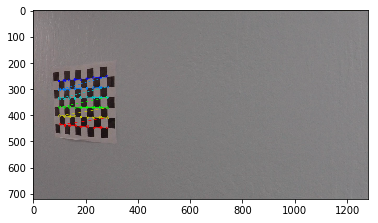

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
plt.show()

## Next, i will correct images for distortion and get the Distortion Coefficient and Camera Matrix for future use

Distortion Coefficient: 
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259867]]
Camera Matrix: 
[[1.15777818e+03 0.00000000e+00 6.67113857e+02]
 [0.00000000e+00 1.15282217e+03 3.86124583e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


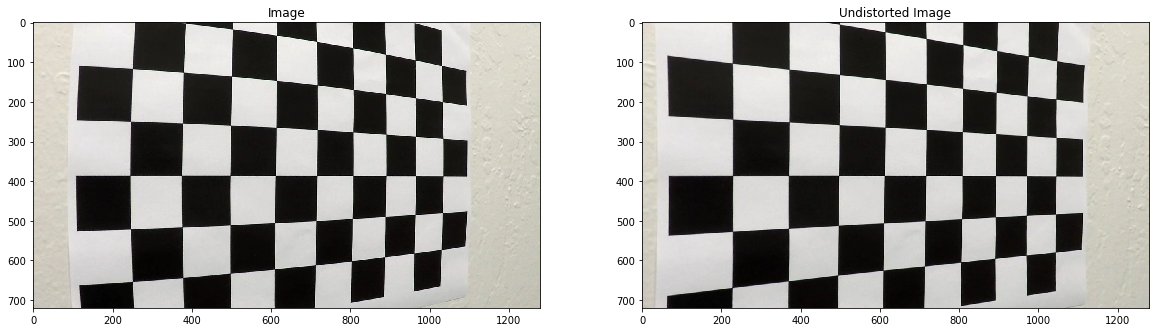

In [2]:
# Using cv2.calibrateCamera() and cv2.undistort() to unditort the images based on previous acquired objpoints and imgpoints
img = plt.imread('camera_cal/calibration5.jpg')

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
undist_chess = cv2.undistort(img, mtx, dist, None, mtx)

# Plotting images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Image')
ax1.imshow(img)

ax2.set_title('Undistorted Image')
ax2.imshow(undist_chess)


print('Distortion Coefficient: ')

print(dist)

print('Camera Matrix: ')

print(mtx)

#Saving example images
plt.imsave('examples/undistort_output.jpg', undist_chess)


## Calculating the transform and inverse transform matrices to warp the street to bird's view and back

In [3]:
# perspective transform constants
img_size = (1280, 720)
offset_x = 300
offset_y = 0

# source and destination points (top left, top right, bottom right, bottom left) for warping street to birds view 
src = np.float32([[600, 450], [690, 450], [1100, 680], [280, 680]])     # these are the coodinates of the street

dst = np.float32([[offset_x, offset_y], [img_size[0]-offset_x, offset_y], [img_size[0]-offset_x, img_size[1]-offset_y], [offset_x, img_size[1]-offset_y]])

# use cv2.getPerspectiveTransform() to get M and Minv, the transform and inverse transform matrices to warp the street to birds view and back
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)

print(dst)


[[300.   0.]
 [980.   0.]
 [980. 720.]
 [300. 720.]]


## Creating a thresholded binary image using color transforms and gradients and applying a perspective transform to rectify binary image ("birds-eye view")

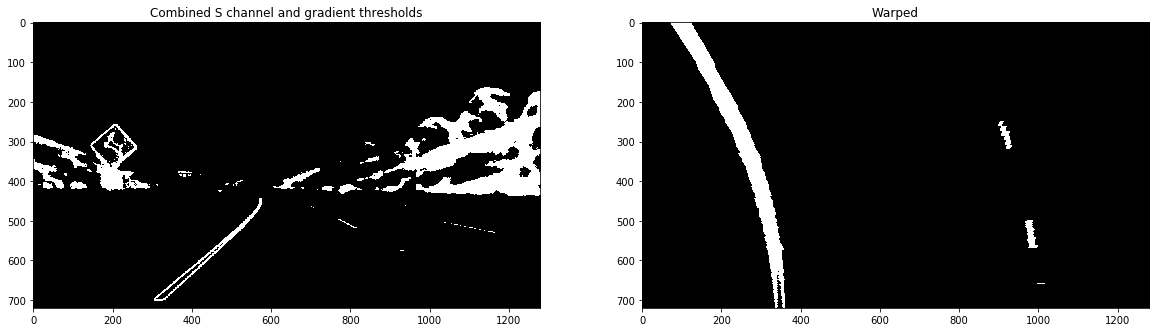

In [4]:
def color_thresholding(img, thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    b_channel = lab[:,:,2]
    l_channel = luv[:,:,0]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    #thresh_min = 20
    #thresh_max = 100
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color luv
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # Threshold color lab
    b_thresh_min = 150
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1

    return combined_binary


def correct_distortion(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def transform_perspective(img, M, img_size):
    return cv2.warpPerspective(img, M, img_size)

def untransform_perspective(img, Minv, img_size):
    return cv2.warpPerspective(img, Minv, img_size)


#Example image    
test_image = plt.imread('test_images/test2.jpg')
undist_test_image = correct_distortion(test_image, mtx, dist)
combined_binary_test_image = color_thresholding(undist_test_image, thresh=(100, 255))
warped_test_image = transform_perspective(combined_binary_test_image, M, img_size )

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Combined S channel and gradient thresholds')
ax1.imshow(combined_binary_test_image, cmap='gray')

ax2.set_title('Warped')
ax2.imshow(warped_test_image, cmap='gray')

#Saving example images
plt.imsave('examples/undistort_road_output.jpg', undist_test_image)
plt.imsave('examples/binary_combo_example.jpg', combined_binary_test_image, cmap="gray")
plt.imsave('examples/warped.jpg', warped_test_image, cmap="gray")


## Line detection using a sliding window algorithm

In [5]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

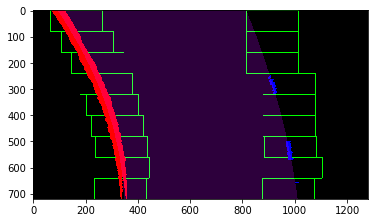

In [6]:
def find_lane_pixels(binary_warped, plot_windows):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if plot_windows:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, plot_windows = True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, plot_windows)

    #Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
                               
    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the window image
    cv2.fillPoly(window_img, np.int_([pts]), (150, 0, 200))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fit, right_fit


#Example image
out_img_example, left_fit_example, right_fit_example = fit_polynomial(warped_test_image)
plt.imshow(out_img_example)

#Saving example images
plt.imsave('examples/color_fit_lines_1.jpg', out_img_example)

In [7]:
# Polynomial fit values from the previous frame
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    #Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the window image
    cv2.fillPoly(window_img, np.int_([pts]), (150, 0, 200))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    return result, left_fit_cr, right_fit_cr


## Measuring Curvature

In [8]:
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return ploty, left_curverad, right_curverad


## Example image output

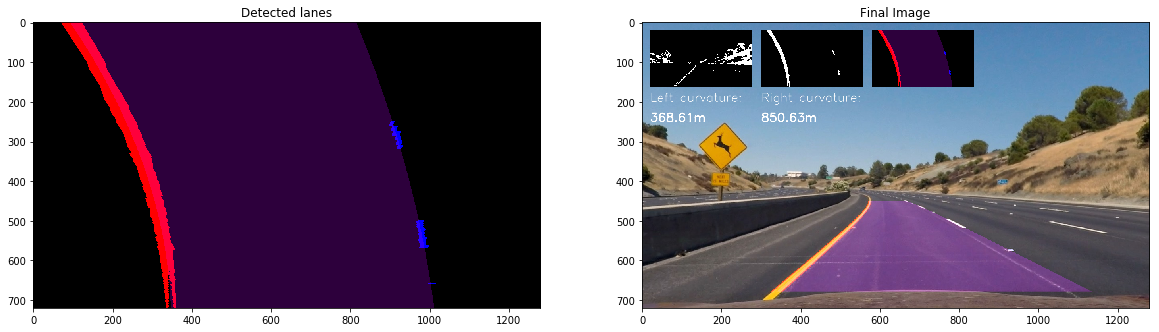

In [9]:
#Example image

#Searching around the discovered lane
out_img_search_example, left_fit_search_example, right_fit_search_example = search_around_poly(warped_test_image, left_fit_example, right_fit_example)
    
result_img_example, left_curverad_example, right_curverad_example = measure_curvature_real(out_img_search_example, left_fit_search_example, right_fit_search_example)

final_result_example = untransform_perspective(result_img_example, Minv, img_size)
weighted_img_example = cv2.addWeighted(undist_test_image, 1, final_result_example, 1, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
#Overlaying curvature values
weighted_img_example = cv2.putText(weighted_img_example, 'Left curvature:', (20,200), font, 1, (255,255,255), 1, cv2.LINE_AA)
weighted_img_example = cv2.putText(weighted_img_example, '{}m'.format(round(left_curverad_example, 2)), (20,250), font, 1, (255,255,255), 2, cv2.LINE_AA)

weighted_img_example = cv2.putText(weighted_img_example, 'Right curvature:', (300,200), font, 1, (255,255,255), 1, cv2.LINE_AA)
weighted_img_example = cv2.putText(weighted_img_example, '{}m'.format(round(right_curverad_example, 2)), (300,250), font, 1, (255,255,255), 2, cv2.LINE_AA)

#Overlaying pipline images

x_offset = y_offset = 20
small = cv2.resize(combined_binary_test_image, (0,0), fx=0.2, fy=0.2)[...,None]*255
weighted_img_example[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small

x_offset = 300
small = cv2.resize(warped_test_image, (0,0), fx=0.2, fy=0.2)[...,None]*255
weighted_img_example[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small

x_offset = 580
small = cv2.resize(result_img_example, (0,0), fx=0.2, fy=0.2) 
weighted_img_example[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small

#plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Detected lanes')
ax1.imshow(result_img_example)

ax2.set_title('Final Image')
ax2.imshow(weighted_img_example)

#Saving example images
plt.imsave('examples/color_fit_lines_2.jpg', result_img_example)
plt.imsave('examples/example_output.jpg', weighted_img_example)

## Using all of the above to create the pipeline

In [10]:
def process_image(image):
    #Running the image through the pipeline
    undist = correct_distortion(image, mtx, dist)
    combined_binary = color_thresholding(undist, thresh=(100, 255))
    warped = transform_perspective(combined_binary, M, img_size )
    
    out_img, left_fit, right_fit = fit_polynomial(warped, False)
    
    #out_img, left_fit, right_fit = search_around_poly(warped, left_fit, right_fit)
    
    result_img, left_curverad, right_curverad = measure_curvature_real(out_img, left_fit, right_fit)
    
    untransformed_image = untransform_perspective(result_img, Minv, img_size)
    weighted_img = cv2.addWeighted(undist, 1, untransformed_image, 1, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    #Overlaying curvature values
    weighted_img = cv2.putText(weighted_img, 'Left curvature:', (20,200), font, 1, (255,255,255), 1, cv2.LINE_AA)
    weighted_img = cv2.putText(weighted_img, '{}m'.format(round(left_curverad, 2)), (20,250), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    weighted_img = cv2.putText(weighted_img, 'Right curvature:', (300,200), font, 1, (255,255,255), 1, cv2.LINE_AA)
    weighted_img = cv2.putText(weighted_img, '{}m'.format(round(right_curverad, 2)), (300,250), font, 1, (255,255,255), 2, cv2.LINE_AA)
    #Overlaying pipline images
    
    x_offset = y_offset = 20
    small = cv2.resize(combined_binary, (0,0), fx=0.2, fy=0.2)[...,None]*255
    weighted_img[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small
    
    x_offset = 300
    small = cv2.resize(warped, (0,0), fx=0.2, fy=0.2)[...,None]*255
    weighted_img[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small
    
    x_offset = 580
    small = cv2.resize(result_img, (0,0), fx=0.2, fy=0.2) 
    weighted_img[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small
    
    return weighted_img


## Test on videos!

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
line_detected = False
video = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [04:55<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 2min 47s, sys: 3.02 s, total: 2min 50s
Wall time: 4min 58s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))